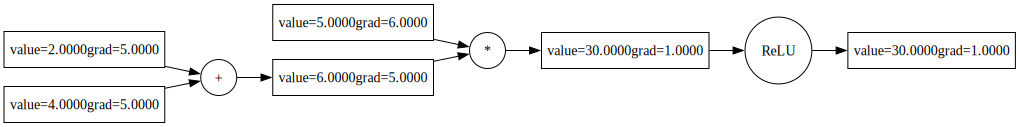

In [ ]:


#things that need to be implemented : 
'''
layers of neurons 
mlp
loss function 
ways to interate
'''
from graphviz import Digraph


def trace(root): #this is a DFS to get all nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        # value node (box)
        dot.node(uid, label=f"value={n.value:.4f}\ngrad={n.grad:.4f}", shape="record")

        # op node (small circle) if this node was produced by an op
        if n.op:
            op_id = uid + n.op
            dot.node(op_id, label=n.op, shape="circle")
            dot.edge(op_id, uid)  # op -> value

    # connect children -> op node (if present), else children -> value node
    for a, b in edges:
        b_uid = str(id(b))
        if b.op:
            dot.edge(str(id(a)), b_uid + b.op)  # child -> op
        else:
            dot.edge(str(id(a)), b_uid)         # leaf case

    return dot

class Node:
    def __init__(self, value, children=(), op=''):
        self.value = value
        self.grad = 0.0
        self._backward = lambda: None
        self.children = children
        self.op = op

    def __add__(self, other):   
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value + other.value, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value - other.value, (self, other), '-')
        def _backward(): 
            self.grad += out.grad
            other.grad += -1*out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value * other.value, (self, other), '*')    
        def _backward(): 
            self.grad += out.grad*other.value
            other.grad += out.grad*self.value
        out._backward = _backward
        return out
    
    def __repr__(self):
        return f"Node(value={self.value}, grad={self.grad}, op='{self.op}')"
    
    def relu(self):
        out = Node(0.0 if self.value < 0 else self.value, (self,), 'ReLU')

        def _backward():
            # d/dx ReLU(x) = 1 if x > 0 else 0
            self.grad += (out.value > 0) * out.grad

        out._backward = _backward
        return out
    
    
    def backward(self):
        visited = set()
        topo = []

        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build(child)
                topo.append(v)

        build(self)

        self.grad = 1.0  # seed here

        for node in reversed(topo):
            node._backward()

    def zero_grad(self):
        nodes, _ = trace(self)
        for n in nodes:
            n.grad = 0.0



n1 = Node(2)
n2 = Node(4)
n3 = n1 + n2
n4 = Node(5)
n5 = n3*n4
L = n5.relu()

#i will call the above a branch 
#i need to make the tree and hence the forest 

#end goal : given an array xs = [1.0,1.5,2.3,3.0] which is basically a vector
# i will feed this into model(xs) which will intake one entry individually 
# and outputs outs = [?,?,?,?] which will be compared to truths [2.0,1.0,2.8,2.5]
# and will train weights to get similar values to the truths 

#the model will accept the input node, multiply by weight #00, add bias #00 
#will have a first layer of 4 neurons which will multipy output of input node by their respective weights 
# #10, #11, #12, #13 with and add their respective biases. #10, #11, #12, #13 
# a second layer which has 16 neuros with weights #20~#215 where #20 will recieve outputs from #10 and #10
# #21 will accept outputs from #10 and #11 ~ #23 will recieve data from #10 and #13 
# finally #15 will recieve outputs from #13 and #13. 
# they will all output to a single node via summation and then use relu 
# output relu and do rms with the actual (truths - outs)^2 = rms^2. 

#we then use backward to get grads. and print weights and biases. (for the weight nodes only) 
# alter the weights += -0.1*grad

#keep on printing the rms^2 value for a lot of times and see if it converges 





L.zero_grad()
L.backward()
dot = draw_dot(L)
dot


In [2]:
class Neuron:
    def __init__(self, nin, nonlin=True):
        self.weight = [Node(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Node(0.0)
        self.nonlin = nonlin

    def __call__(self, xss):
        xs = [xi if isinstance(xi,Node) else Node(xi) for xi in xss]
        out = self.bias
        for wi, xi in zip(self.weight, xs):
            out = out + xi*wi
        return out.relu() if self.nonlin else out

    def parameters(self):
        return self.weight + [self.bias]


In [3]:
class layers:
    def __init__(self, nin, nly, nonlin=True):
        self.neurons = [Neuron(nin, nonlin=nonlin) for _ in range(nly)]

    def __call__(self, xs):
        xs = [xi if isinstance(xi,Node) else Node(xi) for xi in xs]
        return [n(xs) for n in self.neurons]

    def parameters(self):
        params = []
        for n in self.neurons:
            params += n.parameters()
        return params


In [4]:
class MLP:
    def __init__(self, nin, layout):
        sz = [nin] + list(layout)
        self.layers = []
        for i in range(len(layout)):
            is_last = (i == len(layout)-1)
            self.layers.append(layers(sz[i], sz[i+1], nonlin=not is_last))

    def __call__(self, xs):
        for layer in self.layers:
            xs = layer(xs)
        return xs

    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params


In [24]:
import random
net = MLP(nin=4, layout=[8,4])

lr = 1e-4
for step in range(40000):
    x = [random.uniform(-5,5) for _ in range(4)]
    y = [2*xi for xi in x]

    y_pred = net(x)  # list of 4 Nodes

    loss = Node(0.0)
    for yp, yt in zip(y_pred, y):
        loss = loss + (yp - yt) * (yp - yt)

    # clear grads (do this on parameters, not loss unless you've implemented loss.zero_grad())
    for p in net.parameters():
        p.grad = 0.0

    loss.backward()

    for p in net.parameters():
        p.value -= lr * p.grad

    if step % 200 == 0:
        print(step, loss.value)


0 220.94499440647806
200 28.41483815178007
400 149.46480676871658
600 7.3894940463197045
800 49.30691295546342
1000 22.589345320293667
1200 3.197703240153832
1400 21.409713645055533
1600 71.72472634501517
1800 10.248475756733157
2000 10.048960847205365
2200 24.950983838657564
2400 6.455324757710312
2600 39.429166773711934
2800 1.621290122602169
3000 11.754368015012806
3200 4.864519565579404
3400 21.043194668956204
3600 46.13555343858636
3800 14.221460882744045
4000 0.2641460089531468
4200 12.79337071357361
4400 4.916276274469135
4600 10.201161319891114
4800 4.929612487548227
5000 1.6394057418389045
5200 3.2545048759741295
5400 13.415755860334553
5600 2.1193209736959266
5800 11.306222999794027
6000 5.324735933055068
6200 22.77497259215691
6400 15.420826125126558
6600 13.994822586170352
6800 6.064517199266012
7000 9.574567018459975
7200 3.8612013748847245
7400 3.5659825826370657
7600 1.1234285340117667
7800 1.0309890573797884
8000 2.2379141439041743
8200 0.9749310626056493
8400 2.6407723

In [25]:
test = [1.0,2.0,3.0,4.0]
pred = net(test)
print([p.value for p in pred])
test = [1.5,1.0,5.0,4.0]
pred = net(test)
print([p.value for p in pred])



[2.119620127144083, 4.060482967241191, 6.0695897258969955, 8.100734041929993]
[2.912497410386359, 1.888388651510681, 10.007948811142144, 7.957876529089786]
